In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    make_scorer,
    
)
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 0)
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import shap, eli5

<br><br><br><br>

# Cancel or Confirm? Predicting whether customers are canceling their hotel bookings.

### Background :
The behavior of customers and booking options have thoroughly altered by the online hotel reservation channels. A significant number of reservations are canceled always, mostly due to cancellations or no-shows. Cancellations can be caused by a variety of factors, such as scheduling conflicts, changes in plans, etc. This is observed more frequently due to the fact that hotels often make it easier for guests to cancel their reservations by offering free or low cost cancellation options. Although this benefits the guests heavily, it may risk the hotel losing on potential revenue. 

Therefore, the outcome of this project is to assist the hotel owners to better understand whether a customer will confirm the booking or cancel it by developing and implementing machine learning methodologies.

##### Source : The dataset used in this project is from Kaggle. Link -> [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv)

### Components of the project:
In order to achieve the project's objective, we concentrated on four primary areas:
>1. Exploratory data analysis
>2. Predictive Modeling
>3. Optimization
>4. Feature importances and selection


### Exploratory data analysis:

In [31]:
data = pd.read_csv("train__dataset.csv")
X = data.drop("booking_status", axis=1)
y = data["booking_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, train_size = 0.7) # setting a random state to make it reproducible

df_train = X_train.join(y_train)
df_train.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000
mean,1.845845,0.106892,0.808980,2.214100,0.313037,0.031902,0.336510,84.945884,2017.821189,7.441985,15.628909,0.806459,0.026073,0.022922,0.159354,103.513689,0.616384,0.324143
std,0.517027,0.410776,0.871795,1.418276,0.623953,0.175747,0.774089,85.788163,0.383209,3.081619,8.779931,0.645516,0.159359,0.379929,1.785368,35.090118,0.790173,0.468072
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.750000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,125.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.000000,1.000000,1.000000
max,4.000000,9.000000,6.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,375.500000,5.000000,1.000000


Based on the summary statistics provided, here are some initial observations about the data:
* There are 12,695 observations in the train dataset.
* The average number of adults per booking is 1.85 while the average number of children per booking is 0.11 <br/>
* On average people visit between July and August, meaning the hotel is busier during summer holidays.
* The average number of nights stayed over a weekend is 0.81 while the average number of nights stayed during the week is 2.21 <br/>
* The average lead time for bookings is 84.95 days, with a standard deviation of 85.79. <br/>
* Only 2.6% of bookings are from repeated guests on average <br/>
* The average price per room is 103.51 <br/>
* The majority of bookings (67.6%) are confirmed, while the remaining 32.4% are canceled. <br/>

Overall, the describe() function provides a good overview of the bookings. However, further analysis and exploration of the data is required to recognise more trend in data .

To identify patterns or trends in the data relative to target class, we can create visualisations of some features for each target classes to see the differences between them.
#### Data visualization:

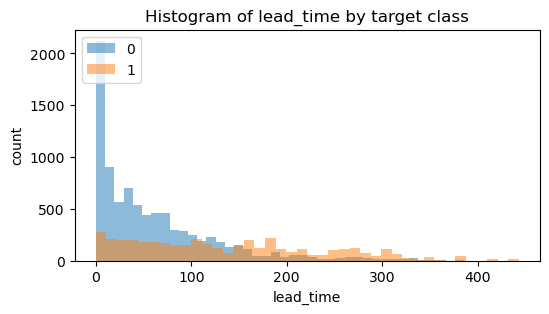

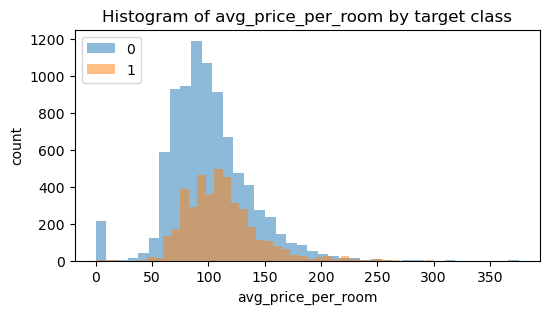

In [32]:
negative_examples = df_train.query("booking_status == 0")
positive_examples = df_train.query("booking_status == 1")

for x in ['lead_time','avg_price_per_room']:
    f = plt.figure()
    f.set_figwidth(6)
    f.set_figheight(3)
    
    plt.title("Histogram of " + x + " by target class")
    plt.hist(negative_examples[[x]], bins = 40, alpha=0.5, label='0')
    plt.hist(positive_examples[[x]], bins = 40, alpha=0.5, label='1')
    plt.legend(loc='upper left')
    plt.ylabel("count")
    plt.xlabel(x)
    plt.show()

Based on the histogram of lead_time by target class :
1. Intially (till lead_time 100), the number of confirmed bookings are more than the number of cancellations.
2. From the first figure, a major proportion of confirmed bookings lie roughly in the range lead_time < 50. 
3. Moreover, as lead time decreases, the number of confirmed bookings increases, mostly from lead_time 150. 
4. From lead_time 150 onwards, the number of cancellations exceed the number of confirmed bookings.

This shows as the number of days between the date of booking and the arrival date increases, the chances of cancelling increases and people more likely to confirm than cancel if the lead time is relatively low (< 100).



Based on the histogram of avg_price_per_room by target class:
1. The number of confirmed bookings are more than the number of cancellations for every average price per room.
2. The number of cancellations and confirmed bookings peak around similar values. It is around 100 for cancellations and a little lower for confirmed bookings.
3. The observable trend for both target class is pyramid shapped, with most datasets lying roughly between avg_price_per_room 50 and 250.  
4. At both peaks, there are roughly 800 more confirmed bookings than cancellations.

This shows people are more likely to confirm their bookings if the average price lies between 50 and 125. For rest of the bookings (outer edges), the probability of confirming is close to the probability of cancelling.

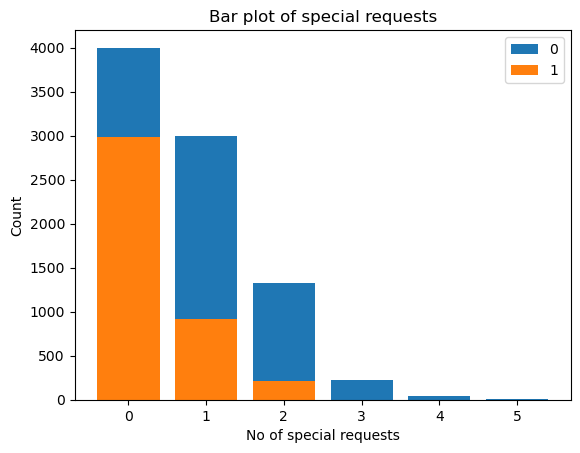

In [33]:
l = 0
for x in [negative_examples,positive_examples]:
    counts = x['no_of_special_requests'].value_counts().to_numpy()
    counts.resize(6)
    plt.bar(df_train['no_of_special_requests'].unique(), counts, label = l)
    plt.legend()
    plt.xlabel("No of special requests")
    plt.ylabel("Count")
    plt.title("Bar plot of special requests")
    l = 1

Based on the bar plot:
1. As the number of special requests increases, the dataset count having those feature value decreases.
2. As the number of special requests increases, the proportion of cancelled bookings decreases with mostly confirmed bookings after no of special requests=2.

This means people with more requests generally do not cancel their bookings as opposed to people who have no or few special requests. 

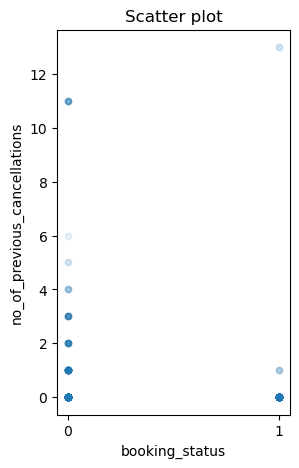

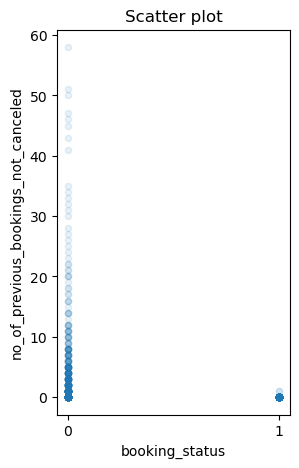

In [34]:
for t in ['no_of_previous_cancellations','no_of_previous_bookings_not_canceled']:
    df_train.plot(kind = "scatter", x ='booking_status', y = t , alpha=0.1, xticks = (0,1), figsize = (3,5), title = "Scatter plot")

From the plots, it is evident that people are more likely to confirm their booking if they have lower number of previous cancellations, with some exceptions. Moreover, if people have previously not cancelled any booking, they are more likely to confirm if the "no_of_previous_bookings_not_canceled" is roughly more 5. People are more likely to cancel if they previously did not confirm any bookings.

### Predictive Modeling:
#### Preprocessing and transformations:

In [35]:
numeric_features = ["no_of_adults", "no_of_children","no_of_weekend_nights","no_of_week_nights", "lead_time", "no_of_previous_cancellations","no_of_previous_bookings_not_canceled","avg_price_per_room","no_of_special_requests", "arrival_month"] # apply scaling
categorical_features = ["type_of_meal_plan", "room_type_reserved", "market_segment_type"] # apply one-hot encoding
binary_features = ["required_car_parking_space", "repeated_guest"] # apply one-hot encoding with drop="if_binary"
drop_features = ["arrival_year", "arrival_date"] # customers make bookings depending on mostly months  
target = "booking_status"

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features),
    ("drop", drop_features),
)

We separate features into numerical and categorical types because they require different types of transformations. We apply one-hot encoding on the categorical features and standard scaling on the numerical features

In this project, we will approach different methods and employ different models. One of such models is a logistic regression model. 

Below is a helper function to make calculating validation scores easier:

In [36]:
# from prev. lectures and assignments
def mean_std_cross_val_scores(model, X_train, y_train, scoring, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    if scoring == "f1":
        scores = cross_validate(model, X_train, y_train, scoring = "f1", **kwargs)
        mean_scores = pd.DataFrame(scores).mean()
        std_scores = pd.DataFrame(scores).std()
        out_col = []

        for i in range(len(mean_scores)):
            out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

        return pd.Series(data=out_col, index=mean_scores.index)
    else:
        scores = cross_validate(model, X_train, y_train, **kwargs)

        mean_scores = pd.DataFrame(scores).mean()
        std_scores = pd.DataFrame(scores).std()
        out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

#### Linear models:

In [37]:
results_dict = {}
C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, C=C))
    results_dict["Logistic Regression with C=" + str(C)] = mean_std_cross_val_scores(
        lr_pipe, X_train, y_train, return_train_score=True, scoring ="accuracy"
    )
    
pd.DataFrame(results_dict)

,Logistic Regression with C=0.01,Logistic Regression with C=0.03162277660168379,Logistic Regression with C=0.1,Logistic Regression with C=0.31622776601683794,Logistic Regression with C=1.0,Logistic Regression with C=3.1622776601683795,Logistic Regression with C=10.0,Logistic Regression with C=31.622776601683793
fit_time,0.025 (+/- 0.002),0.031 (+/- 0.004),0.040 (+/- 0.001),0.056 (+/- 0.002),0.080 (+/- 0.006),0.108 (+/- 0.007),0.135 (+/- 0.007),0.134 (+/- 0.019)
score_time,0.005 (+/- 0.000),0.004 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.000)
test_score,0.798 (+/- 0.009),0.800 (+/- 0.007),0.802 (+/- 0.006),0.802 (+/- 0.006),0.803 (+/- 0.006),0.803 (+/- 0.006),0.803 (+/- 0.006),0.803 (+/- 0.006)
train_score,0.798 (+/- 0.003),0.800 (+/- 0.003),0.803 (+/- 0.003),0.803 (+/- 0.002),0.804 (+/- 0.002),0.804 (+/- 0.002),0.804 (+/- 0.002),0.804 (+/- 0.002)


From the above observations, we can conclude that changing C values after a specific threshold does not affect the training scores. Thus, we should try optimizing a different hyperparameter or try using another model and optimize it to get a better model. 

Therefore, we try using another model with a different estimator. Since  linear models seemed to be at its limit, we can improve our results by exploring the use of non-linear estimators and evaluating their effectiveness.

#### Non-linear models:

In [38]:
results_dict = {}
models = {
    "Decision Trees": DecisionTreeClassifier(random_state=111),
    "kNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state = 111)
}

for x in models:
    for y in ["accuracy", "f1"]:
        pipe = make_pipeline(preprocessor, models[x])
        results_dict[x + " " + str(y)] = mean_std_cross_val_scores(
            pipe, X_train, y_train, return_train_score=True, scoring = y)
        
pd.DataFrame(results_dict)

,Decision Trees accuracy,Decision Trees f1,kNN accuracy,kNN f1,Random Forest accuracy,Random Forest f1
fit_time,0.039 (+/- 0.002),0.037 (+/- 0.001),0.011 (+/- 0.001),0.011 (+/- 0.000),1.115 (+/- 1.803),0.295 (+/- 0.004)
score_time,0.005 (+/- 0.000),0.005 (+/- 0.001),0.179 (+/- 0.052),0.156 (+/- 0.001),0.031 (+/- 0.001),0.032 (+/- 0.003)
test_score,0.845 (+/- 0.005),0.763 (+/- 0.007),0.832 (+/- 0.006),0.732 (+/- 0.008),0.883 (+/- 0.006),0.810 (+/- 0.010)
train_score,0.996 (+/- 0.000),0.994 (+/- 0.001),0.882 (+/- 0.002),0.812 (+/- 0.004),0.996 (+/- 0.000),0.994 (+/- 0.001)


Based on the mean test scores, Random Forest seems to be performing the best, with an mean test score around 0.883. This is followed by Decision Trees with a score 0.845, and kNN with a score 0.832. Random Forest also have the best f1 score meaning that it can correctly identify both positive and negative examples with the highest accuracy among the rest of the models. 

Given that the Random Forest model is the most effective among other models, we will focus on optimizing its hyperparameters to improve its performance. 

### Optimization:
We will look to optimize the hyperparameters max_depth, n_estimators and class_weight. We will use random search, an automated technique to find the best set of hyperparameters.

In [39]:
rf = RandomForestClassifier(n_jobs=-1, random_state=111)
ac_search_results = []
best_accuracy = 0
best_accuracy_params = []

f1_search_results =[]
best_f1 = 0
best_f1_params = []

param_grid = {"randomforestclassifier__max_depth": [10, 20, 30, 40, 50],
             "randomforestclassifier__n_estimators": [50, 100, 200, 250, 300],
             "randomforestclassifier__class_weight": [None, {0:1, 1:3},'balanced']}

pipe = make_pipeline(preprocessor, rf)
random_search = RandomizedSearchCV(
    pipe, param_grid, cv=5, return_train_score=True, n_iter=15, random_state=111
)
random_search.fit(X_train, y_train)
for x in ["accuracy", "f1"]:
    pipe = make_pipeline(preprocessor, rf)
    random_search = RandomizedSearchCV(
        pipe, param_grid, cv=5, return_train_score=True, n_iter=15, random_state=111, scoring = x
    )
    random_search.fit(X_train, y_train)
    if x == "accuracy":
        ac_search_results = pd.DataFrame(random_search.cv_results_)
        best_accuracy = random_search.best_score_
        best_accuracy_params = random_search.best_params_
    else:
        f1_search_results = pd.DataFrame(random_search.cv_results_)
        best_f1 = random_search.best_score_
        best_f1_params = random_search.best_params_

In [40]:
print(best_accuracy_params, best_accuracy)
print(best_f1_params, best_f1)

{'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__class_weight': 'balanced'} 0.8844426939740055
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__class_weight': {0: 1, 1: 3}} 0.8158630987451104


At first glance, the accuracy is more improved than the what we got intially. Also, the f1 increased slightly. The best f1 params and accuracy params differ by just the class weight. Looking at the f1_search_results and ac_search_ results, the difference between the accuracies and f1 scores between these two params is trivial for both optimum parameters. Therefore, we pick the best f1 params as the accuracy score (for best f1 params) is slightly lower than its best score. Also, we can afford to lose a very small accuracy score for a better f1 score. Moreover, using lower n_estimators will make fitting faster. 

#### Therefore, the final optimized model: 
>RandomForestClassifier(n_estimators = 200, max_depth=20, class_weight = {0: 1, 1: 3})

### Feature importances and selection:
An important part of this project involved creating and transforming the features used in our model, given a rather large amount of raw data. First, we need to find which features are important to the model. Then, we will use feature selection to select specific features to make our model simpler and better.

#### Feature importances:
We will use eli5 to view which features are important.

In [41]:
X_train_pp = preprocessor.fit_transform(X_train)

column_names = numeric_features + list(
    preprocessor.named_transformers_["onehotencoder-1"].get_feature_names_out(categorical_features)) + list(
    preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out(binary_features))

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators = 200, max_depth=20, n_jobs=-1, random_state=111, class_weight = {0: 1, 1: 3}))
pipe_rf.fit(X_train, y_train)
eli5.explain_weights(pipe_rf.named_steps["randomforestclassifier"], feature_names=column_names)

Weight,Feature
0.3301 ± 0.0448,lead_time
0.1631 ± 0.0372,avg_price_per_room
0.1301 ± 0.0478,no_of_special_requests
0.1037 ± 0.0224,arrival_month
0.0589 ± 0.0154,no_of_week_nights
0.0436 ± 0.0147,no_of_weekend_nights
0.0362 ± 0.0483,market_segment_type_1
0.0249 ± 0.0128,no_of_adults
0.0227 ± 0.0348,market_segment_type_0
0.0123 ± 0.0060,required_car_parking_space_1


From the table: 
* lead_time, avg_price_per_room, no_of_special_requests and arrival month have the highest weight among all the features(>0.1).
* no_of_week_nights, no_of_weekend_nights , market_segment_type_1, and no_of_adults have moderate to low weight.
* The rest of the features have very low to no weight. 
* lead_time is the most important feature, followed by avg_price_per_room and no_of_special_requests.

#### Feature selection:
We will use RFECV to select the number of features to use in our model. It uses cross-validation to select number of features.

In [42]:
model = RandomForestClassifier(n_estimators = 200, max_depth=20, class_weight = {0: 1, 1: 3})
rfe_cv = RFECV(model, cv=10,n_jobs=-1)
rfe_cv.fit(X_train_pp, y_train)

print('Original number of features:', X_train_pp.shape[1])
print('Number of selected features:', sum(rfe_cv.support_), '\n\n')
print("Selected features: ", np.array(column_names)[rfe_cv.support_])

Original number of features: 28
Number of selected features: 17 


Selected features:  ['no_of_adults' 'no_of_children' 'no_of_weekend_nights'
 'no_of_week_nights' 'lead_time' 'avg_price_per_room'
 'no_of_special_requests' 'arrival_month' 'type_of_meal_plan_0'
 'type_of_meal_plan_1' 'type_of_meal_plan_2' 'room_type_reserved_0'
 'room_type_reserved_1' 'market_segment_type_0' 'market_segment_type_1'
 'market_segment_type_2' 'required_car_parking_space_1']


As seen from the results, we have managed to reduce the number of features considerably (by half). Next, we will use this to check whether our model has improved or how much it improved. 


In [43]:
new_train = rfe_cv.transform(X_train_pp)

print('accuracy scores:\n \n', mean_std_cross_val_scores(
    model, new_train, y_train, return_train_score=True, scoring ="accuracy"
),'\n \n','f1 scores:\n \n', mean_std_cross_val_scores(
    model, new_train, y_train, return_train_score=True, scoring ="f1"
))


accuracy scores:
 
 fit_time       1.507 (+/- 0.041)
score_time     0.079 (+/- 0.001)
test_score     0.882 (+/- 0.007)
train_score    0.987 (+/- 0.001)
dtype: object 
 
 f1 scores:
 
 fit_time       1.494 (+/- 0.019)
score_time     0.080 (+/- 0.001)
test_score     0.815 (+/- 0.006)
train_score    0.982 (+/- 0.001)
dtype: object


The accuracy scores and f1 scores increased very slightly but it is still a major improvement since our model is much simpler and considers lower parameters. 

We have a proper model and have selected important features to train our model. Now, we will check how the model works on unseen datasets.

### Results on test set and overall summary :

In [44]:
model.fit(new_train,y_train)
new_test = preprocessor.transform(X_test)
new_test = rfe_cv.transform(new_test)

accuracy_testscore = model.score(new_test, y_test)
f1_testscore = f1_score(y_test, model.predict(new_test))
print("Accuracy: " + str(accuracy_testscore))
print("F1 score: " + str(f1_testscore))

Accuracy: 0.8868063212054392
F1 score: 0.8276440962506995


From the train and test scores above:
* It has good test scores meaning it effectively classifies the data into their respective classes.
* The test scores agree with the validation scores from before. 
* The test values are overfit. The predictions have high variance among them but low bias. 
* The difference in train/test value means the model might not generalize well to new unseen data.

### Model caveats and final thoughts:

Throughout the project, the models created and methods used might not be best and the following results might not be perfect. Having said that, the following caveats can be inferred: 

* Generalizability: The significant difference between train accuracy/F1 score and test F1 accuracy/F1 score means that the model could be overfitting the training data. As a result, it might not generalize well to unseen data. This is mainly due to the fact we are using an ensemble model and other steps we took to optimize it such as RFECV, random search. 
* Suboptimal search results: Using grid search instead of random search could have provided better performing parameters since it is an exhaustive search. The hyperparameters found might be suboptimal compared to what we could have found using grid search.
* Time series relationships: The relationship between the features and booking_status can change across the years/different dates. Since we did not consider time series analysis, we might have missed underlying patterns in the data, resulting in suboptimal model performance.
* Complexity: Since we used an ensemble model, the model is complex and requires high computational power. Therefore, it is harder to understand or interpret the model, and its training time is also higher than usual.
* Non-important features: RFECV might not have identified all the redundant features, which can increase model complexity and negatively impact the its performance.

Overall, the model still works as an useful tool to assist the hotel owners in better understanding whether a customer will honor the reservation or cancel it. Although the model is far from perfect, it can always be improved or further optimized. Training the model with new data sets occasionally will also improve the models performance in making informed decisions about managing hotel reservations.

<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

Providing a clear and concise answer, and then using supporting texts, figures or any other explanations to support that answer is one communication technique I used in my post. It is easier for the reader to understand since the analysis statements are centered while the elaborate explanations for it is separate to provide full understanding of the content to the readers.

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> Mostly a sense of accomplishment and newfound confidence and knowledge regarding ML. It also developed curiosity in me and I am planning to explore some of the optional topics (eg. deep learning) mentioned in the lecture.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 